# Analysis of political text, it's vectorization etc.

**Step 1: Load text from dataset and store political words in a list**

In [2]:
# imports section 
import csv
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

import numpy as np
import matplotlib.pyplot as plt
import math
import random

import skfuzzy as fuzz
from skfuzzy import control as ctrl

import gensim.downloader as api
from gensim.models import Word2Vec
import itertools

In [13]:
words = []
common_words = [
    "the", "be", "to", "of", "and", "a", "in", "that", "have", "i", "it", "for", "not", "on", "with",
    "he", "as", "you", "do", "at", "this", "but", "his", "by", "from", "they", "we", "say", "her", "she",
    "or", "an", "will", "my", "one", "all", "would", "there", "their", "what", "so", "up", "out", "if",
    "about", "who", "get", "which", "go", "me", "when", "make", "can", "like", "time", "no", "just",
    "him", "know", "take", "people", "into", "year", "your", "good", "some", "could", "them", "see",
    "other", "than", "then", "now", "look", "only", "come", "its", "over", "think", "also", "back",
    "after", "use", "two", "how", "our", "work", "first", "well", "way", "even", "new", "want", "because",
    "any", "these", "give", "day", "most", "us"
]

lemmatizer = WordNetLemmatizer()

with open("../resources/political/political_social_media.csv", newline="", encoding="utf8", errors="ignore") as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        for token in row[20].split(' '):
            word_lemmatized = lemmatizer.lemmatize(token.lower())
            if word_lemmatized not in common_words:
                words.append(word_lemmatized)

print(words[:50])

['text', 'rt', '@nowthisnews:', 'rep.', 'trey', 'radel', '(r-', '#fl)', 'slam', '#obamacare.', '#politics', 'https://t.co/zvywmg8yih', 'video', '-', '#obamacare:', '', 'full', 'higher', 'cost', 'broken', 'promises:', 'http://t.co/dn3vzqirwf', 'please', 'join', 'today', 'remembering', 'fallen', 'hero', 'honoring', 'men', 'woman', 'currently', 'military', 'service', 'sacrifices.', 'rt', '@senatorleahy:', '1st', 'step', 'toward', 'senate', 'debate', 'leahy-crapo', '#vawa', 'bill', 'is', 'senate�۪s', 'procedural', 'vote', 'today']


**Let's try this oxford dictionary of politics** 

In [4]:
import requests
from bs4 import BeautifulSoup
import time

base_link = "https://www.oxfordreference.com/display/10.1093/acref/9780199207800.001.0001/acref-9780199207800?btog=chap&hide=true&page=1&pageSize=20&skipEditions=true&sort=titlesort&source=%2F10.1093%2Facref%2F9780199207800.001.0001%2Facref-9780199207800"

links = []  # your list of links
titles = []

for i in range(80):
    page = f"page={i+1}"
    link = base_link.replace("page=1", page)
    links.append(link)

for url in links:
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    h2_elements = soup.find_all("h2", class_="itemTitle")
    for h2 in h2_elements:
        a_tag = h2.find("a")
        if a_tag:
            titles.append(a_tag.get_text(strip=True))

print(titles)

[]


In [16]:
import requests
import fitz  # PyMuPDF

common_words = [
    "the", "be", "to", "of", "and", "a", "in", "that", "have", "i", "it", "for", "not", "on", "with",
    "he", "as", "you", "do", "at", "this", "but", "his", "by", "from", "they", "we", "say", "her", "she",
    "or", "an", "will", "my", "one", "all", "would", "there", "their", "what", "so", "up", "out", "if",
    "about", "who", "get", "which", "go", "me", "when", "make", "can", "like", "time", "no", "just",
    "him", "know", "take", "people", "into", "year", "your", "good", "some", "could", "them", "see",
    "other", "than", "then", "now", "look", "only", "come", "its", "over", "think", "also", "back",
    "after", "use", "two", "how", "our", "work", "first", "well", "way", "even", "new", "want", "because",
    "any", "these", "give", "day", "most", "us"
]

data = ''

with open('../resources/sets/english-adjectives.txt', 'r') as file:
    data = file.read().replace('\n', ',')

adjectives = data.split(',')

with open('../resources/sets/english-nouns.txt', 'r') as file:
    data = file.read().replace('\n', ',')

nouns = data.split(',')

common_words.extend(adjectives)
common_words.extend(nouns)


# Step 1: Download the PDF
pdf_url = "https://assets.openstax.org/oscms-prodcms/media/documents/Introduction_to_Political_Science_-_WEB.pdf"
response = requests.get(pdf_url)

with open("temp.pdf", "wb") as f:
    f.write(response.content)

# Step 2: Open and parse the PDF
doc = fitz.open("temp.pdf")
words = []

for page in doc:
    text = page.get_text()
    for word in text.split():
        # Clean up word: remove punctuation, make lower case
        clean_word = ''.join(char for char in word if char.isalnum()).lower()
        if clean_word and not clean_word.isdigit() and clean_word not in common_words:
            words.append(clean_word)

doc.close()

# Step 3: Optional: remove duplicates
unique_words = sorted(set(words))

# Step 4: Save to file (optional)
with open("../resources/sets/extracted_words_political.txt", "w", encoding="utf-8") as f:
    for word in unique_words:
        f.write(f"{word}\n")

print(f"Extracted {len(unique_words)} unique words.")

Extracted 17865 unique words.


In [17]:
moods = {0: "economy", 1: "ecology", 2: "populism", 3: "social", 4: "religion", 5: "patriotism"}
moods_indeces = {y.lower(): x for x, y in moods.items()}

lexicon = {
    "fascism": [0.1, 0.1, 0.9, 0.1, 0.7, 0.9],
    "peaceful": [0.1, 0.9, 0.2, 0.9, 0.4, 0.2],
    "pacifism": [0.1, 0.9, 0.2, 0.9, 0.4, 0.2],
    "capitalism": [0.9, 0.2, 0.5, 0.4, 0.3, 0.6],
    "capitalist": [0.9, 0.2, 0.5, 0.4, 0.3, 0.6],
    "socialism": [0.7, 0.5, 0.3, 0.8, 0.2, 0.3],
    "communism": [0.8, 0.6, 0.6, 0.9, 0.1, 0.2],
    "green": [0.3, 0.95, 0.2, 0.7, 0.1, 0.3],
    "conservative": [0.6, 0.3, 0.7, 0.4, 0.8, 0.8],
    "liberal": [0.7, 0.7, 0.4, 0.9, 0.3, 0.4],
    "nationalism": [0.4, 0.2, 0.8, 0.3, 0.6, 1.0],
    "patriot": [0.4, 0.3, 0.6, 0.5, 0.5, 1.0],
    "isolationism": [0.3, 0.4, 0.7, 0.3, 0.5, 0.9],
    "progressive": [0.6, 0.8, 0.3, 0.9, 0.2, 0.3],
    "reactionary": [0.5, 0.2, 0.7, 0.2, 0.7, 0.8],
    "libertarian": [0.8, 0.5, 0.4, 0.6, 0.3, 0.4],
    "anarchism": [0.2, 0.5, 0.9, 0.7, 0.1, 0.1],
    "democracy": [0.6, 0.6, 0.3, 0.9, 0.4, 0.5],
    "authoritarian": [0.3, 0.2, 0.9, 0.3, 0.6, 0.8],
    "technocracy": [0.9, 0.7, 0.2, 0.5, 0.2, 0.3],
    "oligarchy": [0.8, 0.2, 0.5, 0.2, 0.3, 0.4],
    "corruption": [0.1, 0.1, 0.8, 0.1, 0.2, 0.2],
    "inequality": [0.2, 0.4, 0.5, 0.9, 0.2, 0.3],
    "reform": [0.6, 0.7, 0.3, 0.8, 0.2, 0.4],
    "revolution": [0.5, 0.6, 0.8, 0.9, 0.2, 0.4],
    "welfare": [0.7, 0.6, 0.2, 0.9, 0.2, 0.3],
    "privatization": [0.9, 0.3, 0.3, 0.5, 0.2, 0.5],
    "public": [0.5, 0.6, 0.2, 0.7, 0.2, 0.3],
    "immigration": [0.4, 0.4, 0.6, 0.6, 0.3, 0.7],
    "border": [0.3, 0.3, 0.7, 0.4, 0.4, 0.9],
    "refugee": [0.3, 0.6, 0.4, 0.8, 0.3, 0.4],
    "climate": [0.2, 1.0, 0.3, 0.7, 0.2, 0.3],
    "sustainability": [0.3, 0.95, 0.2, 0.8, 0.2, 0.3],
    "taxation": [1.0, 0.2, 0.4, 0.6, 0.3, 0.5],
    "inflation": [0.95, 0.1, 0.3, 0.4, 0.2, 0.3],
    "unemployment": [0.9, 0.3, 0.4, 0.8, 0.2, 0.4],
    "regulation": [0.7, 0.6, 0.3, 0.7, 0.3, 0.4],
    "freedom": [0.6, 0.6, 0.5, 0.9, 0.5, 0.7],
    "censorship": [0.3, 0.2, 0.8, 0.3, 0.5, 0.6],
    "secular": [0.4, 0.4, 0.2, 0.6, 0.1, 0.3]
    }


In [18]:
with open("../resources/sets/extracted_words_political.txt", "a", encoding="utf-8") as f:
    for word in lexicon.keys():
        f.write(f"{word}\n")

In [4]:
corpus = api.load('glove-wiki-gigaword-100')

vector = corpus['computer']
print(vector)

[-1.6298e-01  3.0141e-01  5.7978e-01  6.6548e-02  4.5835e-01 -1.5329e-01
  4.3258e-01 -8.9215e-01  5.7747e-01  3.6375e-01  5.6524e-01 -5.6281e-01
  3.5659e-01 -3.6096e-01 -9.9662e-02  5.2753e-01  3.8839e-01  9.6185e-01
  1.8841e-01  3.0741e-01 -8.7842e-01 -3.2442e-01  1.1202e+00  7.5126e-02
  4.2661e-01 -6.0651e-01 -1.3893e-01  4.7862e-02 -4.5158e-01  9.3723e-02
  1.7463e-01  1.0962e+00 -1.0044e+00  6.3889e-02  3.8002e-01  2.1109e-01
 -6.6247e-01 -4.0736e-01  8.9442e-01 -6.0974e-01 -1.8577e-01 -1.9913e-01
 -6.9226e-01 -3.1806e-01 -7.8565e-01  2.3831e-01  1.2992e-01  8.7721e-02
  4.3205e-01 -2.2662e-01  3.1549e-01 -3.1748e-01 -2.4632e-03  1.6615e-01
  4.2358e-01 -1.8087e+00 -3.6699e-01  2.3949e-01  2.5458e+00  3.6111e-01
  3.9486e-02  4.8607e-01 -3.6974e-01  5.7282e-02 -4.9317e-01  2.2765e-01
  7.9966e-01  2.1428e-01  6.9811e-01  1.1262e+00 -1.3526e-01  7.1972e-01
 -9.9605e-04 -2.6842e-01 -8.3038e-01  2.1780e-01  3.4355e-01  3.7731e-01
 -4.0251e-01  3.3124e-01  1.2576e+00 -2.7196e-01 -8

In [19]:
data = ''

with open('../resources/sets/extracted_words_political.txt', 'r', encoding='utf-8') as file:
    data = file.read().replace('\n', ',')

adjectives = data.split(',')

adjectives_vectors = {}

for adjective in adjectives:
    if adjective in corpus:
        adjectives_vectors[adjective] = corpus[adjective]

# print(adjectives_vectors)
for key, value in itertools.islice(adjectives_vectors.items(), 2):
    print(key, ":", value)

100th : [ 0.19348   -0.8178     0.32432    0.25326    0.18411    0.0352
  0.46999    0.13737   -1.514      0.5503    -0.021126  -0.6258
  0.36069   -0.37285   -0.47407    0.22117    1.1149    -0.082012
  0.10966   -0.38538    0.7509    -0.20423    0.23796    0.519
  0.7336     0.30719   -0.26219    0.40618    0.74649   -0.18267
 -1.0188     0.61514    0.59249    0.69975    0.0075736  0.020971
 -0.48035    0.22963   -0.74554    0.23744    0.78658    0.64549
  1.0984     0.044187  -0.078636   0.68148    0.77727   -0.56556
 -0.15958   -0.65114    0.25665   -0.46841   -0.42649   -0.095074
 -1.078     -1.1337     0.14319    0.14128    0.25139   -0.095647
 -0.78703    0.84587    0.4157     0.11542   -0.37325    0.086721
 -0.38735   -0.076542  -0.32453   -0.49925    0.511      0.18858
 -0.15636    0.035946   0.0083158  0.50221   -0.1362    -0.59044
 -0.55234   -0.15508   -0.34072    0.4286     0.8285     0.081407
 -0.57029   -0.71944   -0.071196  -0.43148    0.64256   -0.060059
 -0.10689    0

In [20]:
# dimensionality reduction via random forest feature extraction, svm in cycle for every component

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

lexicon_embedded = {}

for word in lexicon.keys():
    lexicon_embedded[word] = adjectives_vectors[word]

lexicon_trained = {}
for key in adjectives_vectors:
    lexicon_trained[key] = [0, 0, 0, 0, 0, 0]

for i in range(6):
    X = np.array(list(lexicon_embedded.values()))
    y = np.array([v[i] for v in lexicon.values()])

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train a Random Forest Regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_scaled, y)

    # Get feature importances
    importance_rf = rf.feature_importances_
    # Get indexes of features with importance > 0.04
    important_feature_indexes = np.where(importance_rf > 0.04)[0]

    # Print result
    print(f"Indexes of most important features for {i}:", important_feature_indexes)

    # Create a pipeline with StandardScaler and SVR, wrapped in MultiOutputRegressor
    model = MultiOutputRegressor(make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1.0)))

    x_train, y_train = [], []
    for key in lexicon.keys():
        important_values = []
        for j in important_feature_indexes:
            important_values.append(adjectives_vectors[key][j])
        x_train.append(important_values)
        y_train.append([lexicon[key][i], 0])

    x_train_np = np.array(x_train)
    y_train_np = np.array(y_train)

    # Train the model
    model.fit(x_train, y_train)

    for key in adjectives_vectors:
        important_values = []
        for j in important_feature_indexes:
            important_values.append(adjectives_vectors[key][j])
        result = model.predict([important_values])
        lexicon_trained[key][i] = result[0][0]

for key, value in itertools.islice(lexicon_trained.items(), 10):
    print(key, ":", value)

# moods = {0: "Angry", 1: "Worried", 2: "Sad", 3: "Calm", 4: "Happy", 5: "Excited"}

Indexes of most important features for 0: [ 3 22 31 79 94 96]
Indexes of most important features for 1: [ 0  2  4  6 37 64]
Indexes of most important features for 2: [15 48 51]
Indexes of most important features for 3: [ 9 37 51 64 71]
Indexes of most important features for 4: [ 5  9 46]
Indexes of most important features for 5: [10 34 48 51 89]
100th : [0.7495647080530137, 0.48872363009600195, 0.36331006046454584, 0.7299082398205041, 0.4361898542434204, 0.28018549704354256]
101st : [0.6359943524464675, 0.5381459216266025, 0.4222939548522548, 0.5697666583895501, 0.24015746684462583, 0.560495199833058]
10th : [0.5356611965770811, 0.49018611694288905, 0.5028812906475373, 0.681645422538885, 0.2673643159534771, 0.522391335228579]
115th : [0.574406914867052, 0.43975654492481725, 0.41584759763077594, 0.5241254386703424, 0.31909735914776816, 0.3057024332248745]
117th : [0.5151371322491735, 0.4660658115343211, 0.6423930021677284, 0.5237059310766238, 0.360369695097457, 0.45775905668009775]
11th

In [ ]:
import csv
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

import numpy as np
import matplotlib.pyplot as plt
import math
import random

import skfuzzy as fuzz
from skfuzzy import control as ctrl

from sklearn.metrics import mean_squared_error



validation_array = [
    [[0.1, 0.1, 0.9, 0.9, 0.9, 0.9], 9 ],
    [[0.9, 0.9, 0.9, 0.9, 0.1, 0.1], -8 ],
    [[0.1, 0.1, 0.1, 0.1, 0.9, 0.9], 9 ]
]

data_array = [row[0] for row in validation_array]
validation = [row[1] for row in validation_array]

moods_dict = {0: "economy", 1: "ecology", 2: "populism", 3: "social", 4: "religion", 5: "patriotism"}
moods_indeces = {y.lower(): x for x, y in moods_dict.items()}

moods = ["economy", "ecology", "populism", "social", "religion", "patriotism"]
mood_score = ["low", "medium", "high"]
predicator = ["or", "and"]
output_score_linguistic = ["high_left", "left", "neutral", "right", "high_right"]

# initial flrb population generation:
population_size = 100
rules_size = 9 # how many rules approximately in each rulebase

def get_random_rule():
    return random.choice(moods) + " " + random.choice(mood_score) + " and " + random.choice(moods) + " " + random.choice(mood_score) + " then " + random.choice(output_score_linguistic)


# initial_population = ["angry medium and worried medium and sad medium and calm medium and happy medium and excited medium then neutral"]

initial_rule = "economy medium and ecology medium and populism medium and social medium and religion medium and patriotism medium then neutral"
flrb_population = []

for i in range(population_size):
    fl_rb = []
    fl_rb.append(initial_rule)
    for j in range(rules_size):
        rule = get_random_rule()
        fl_rb.append(rule)
    flrb_population.append(fl_rb)

print(flrb_population[1])

emotion_intensity = np.arange(0, 11, 1)  # This could represent 0 to 10 scale of intensity
output_score = np.arange(-10, 11, 1)     # This could represent a score from -10 (Highly Negative) to 10 (Highly Positive)

antecedents = []

# Create the fuzzy variables for inputs and output
for i in range(len(moods_dict)):
    antecedents.append(ctrl.Antecedent(emotion_intensity, moods_dict[i]))

output = ctrl.Consequent(output_score, 'output')

# Define fuzzy sets and membership functions for each variable
for item in antecedents:
    item.automf(names=['low', 'medium', 'high'])


output['high_left'] = fuzz.trimf(output_score, [-10, -7, -4])
output['left'] = fuzz.trimf(output_score, [-7, -4, -1])
output['neutral'] = fuzz.trimf(output_score, [-3, 0, 3])
output['right'] = fuzz.trimf(output_score, [1, 4, 7])
output['high_right'] = fuzz.trimf(output_score, [4, 7, 10])

def calculate_fuzzy(data_points, rulebase):
    rules = []
    for rule in rulebase:
        predicates = rule.lower().split(' ')
        ant_predicates = antecedents[moods_indeces[predicates[0]]][predicates[1]]
        i = 2
        while i < len(predicates) - 2:
            if predicates[i] == 'or':
                ant_predicates = ant_predicates | antecedents[moods_indeces[predicates[i+1]]][predicates[i+2]]
            else:
                ant_predicates = ant_predicates & antecedents[moods_indeces[predicates[i+1]]][predicates[i+2]]
            i += 3
        rules.append(ctrl.Rule(ant_predicates, output[predicates[len(predicates) - 1]]))

    # Create the control system and simulation
    emotion_ctrl = ctrl.ControlSystem(rules)
    emotion_sim = ctrl.ControlSystemSimulation(emotion_ctrl)
    output_vector = []

    # Pass inputs to the ControlSystem using Antecedent labels with Pythonic API
    for data_point in data_points:
        for i,aggregated_mood in enumerate(data_point):
            emotion_sim.input[moods_dict[i]] = (aggregated_mood) * 10
        emotion_sim.compute()
        output_vector.append(emotion_sim.output['output'])

    # Crunch the numbers
    
    # output.view(sim=emotion_sim)
    return output_vector

def generate_new_population(progenitors, number_successors=50, number_random=40):
    new_population = list(progenitors)
    for i in range(number_successors):
        prog = random.sample(range(0, len(progenitors)), 2)
        fl_rb = []
        for j in range(rules_size):
            fl_rb.append(progenitors[random.choice(prog)][j])
        new_population.append(fl_rb)
    
    for i in range(number_random):
        fl_rb = []
        fl_rb.append(initial_rule)
        for j in range(rules_size):
            rule = get_random_rule()
            fl_rb.append(rule)
        new_population.append(fl_rb)

    return new_population


steps = 100
for i in range(steps):
    mse = []
    results = []
    for rulebase in flrb_population:
        res = calculate_fuzzy(data_array, rulebase)
        results.append(res)
        mse.append(mean_squared_error(validation, res))
    prog = []
    smallest_10_indices = sorted(range(len(mse)), key=lambda i: mse[i])[:10]
    for j in range(len(flrb_population)):
        if(j in smallest_10_indices):
            prog.append(flrb_population[j])
    
    new_population = generate_new_population(prog)
    if i % 5 == 0:
        print(f'step: {i}, average mse: {sum(mse) / len(mse)}')
    flrb_population = list(new_population)
    print(sum(mse) / len(mse))
    i += 1

min_mse = mse.index(min(mse))
flrb_min = flrb_population[min_mse]
print(f'minimal mse: {min(mse)}')
print(flrb_min)

['economy medium and ecology medium and populism medium and social medium and religion medium and patriotism medium then neutral', 'social high and social high then high_right', 'economy low and ecology low then high_right', 'economy low and populism low then high_left', 'populism low and populism medium then high_left', 'social low and social low then right', 'patriotism low and religion low then neutral', 'economy low and ecology medium then neutral', 'populism medium and populism high then left', 'populism high and ecology low then high_right']
step: 0, prog len: 10, flrb len: 100, new len: 100
83.44292928335088
63.76143212074285
51.76950017245106
48.4272864617564
43.541678479424725
40.512361844291256
38.10983650811536
40.5337008188956
39.96598807251238
39.681573086071204
step: 10, prog len: 10, flrb len: 100, new len: 100
39.72523549066196
36.79433517590035
41.31726356569893
39.764104206643125
41.76051636542476
38.01018350426228
41.509416448873374
39.88522343839308
41.3933778495230

**TODO:**
1. Improve filtering of political words! (may be find better datasets with political words)
2. RF feature extraction + SVM
3. Variability Analysis, statistics (ask for a good book in statistics)
4. Our word vectorizations follow normal distribution -> we have to use it 
5. FL automated rule generation
6. 
7. 
8. 

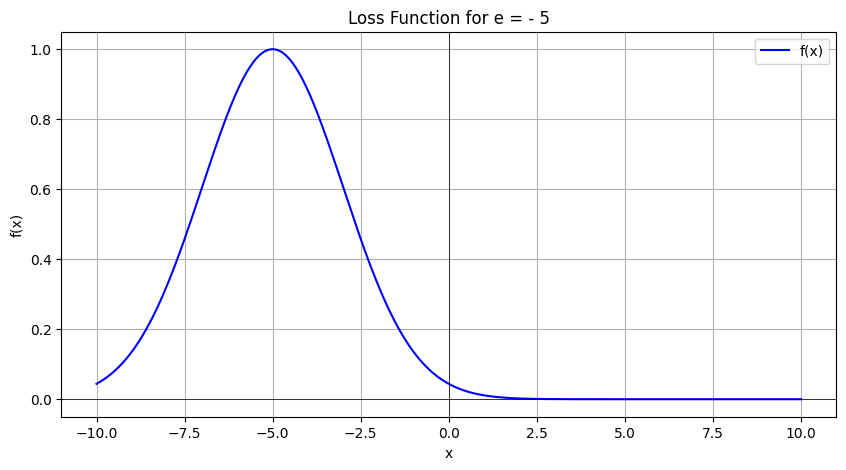

In [24]:
# rate function

def f(x):
    return np.exp(- ((x + 5 )**2) / 8)

x = np.linspace(-10, 10, 400)  # 400 points for smooth plotting
y = f(x)  # Compute y values

plt.figure(figsize=(10, 5))
plt.plot(x, y, label="f(x)", color="blue")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Loss Function for e = - 5")
plt.axhline(0, color="black", linewidth=0.5)  # X-axis
plt.axvline(0, color="black", linewidth=0.5)  # Y-axis
plt.legend()
plt.grid(True)
plt.show()

def loss_function(x, e):
    return np.exp(- ((x - e)**2) / 2)

['excited high or calm low then negative', 'sad high and excited medium then high_negative']
-5.372046893347531e-17


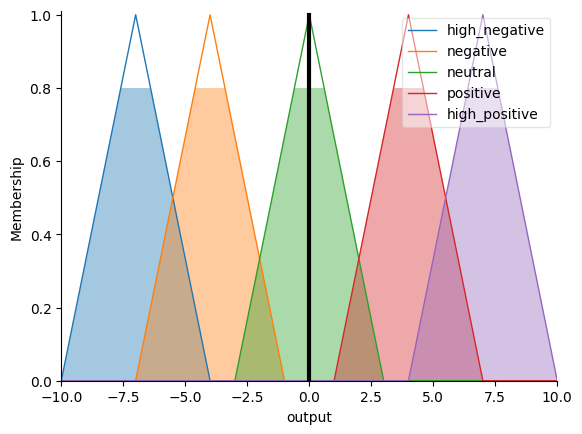

In [ ]:
validation_array = [
    [[0.1, 0.1, 0.9, 0.9, 0.1, 0.1], -5 ],
    [[0.9, 0.9, 0.1, 0.1, 0.1, 0.1], -8 ],
    [[0.1, 0.1, 0.1, 0.1, 0.9, 0.9], 9 ]
]

data_array = [row[0] for row in validation_array]

moods_dict = {0: "angry", 1: "worried", 2: "sad", 3: "calm", 4: "happy", 5: "excited"}
moods_indeces = {y.lower(): x for x, y in moods_dict.items()}

moods = ["angry", "worried", "sad", "calm", "happy", "excited"]
mood_score = ["low", "medium", "high"]
predicator = ["or", "and"]
output_score = ["high_negative", "negative", "neutral", "positive", "high_positive"]

# initial population generation:
population_size = 100
# initial_population = ["angry medium and worried medium and sad medium and calm medium and happy medium and excited medium then neutral"]
initial_population = ["angry medium and worried medium and sad medium and calm medium and happy medium and excited medium then neutral"]

for i in range(population_size):
    rule = moods[random.randint(0, len(moods) - 1)] + " " + mood_score[random.randint(0, len(mood_score) - 1)] + " " + predicator[random.randint(0, len(predicator) - 1)] + " " + moods[random.randint(0, len(moods) - 1)] + " " + mood_score[random.randint(0, len(mood_score) - 1)] + " then " + output_score[random.randint(0, len(output_score) - 1)]
    initial_population.append(rule)

print(initial_population[:2])

emotion_intensity = np.arange(0, 11, 1)  # This could represent 0 to 10 scale of intensity
output_score = np.arange(-10, 11, 1)     # This could represent a score from -10 (Highly Negative) to 10 (Highly Positive)

antecedents = []

# Create the fuzzy variables for inputs and output
for i in range(len(moods_dict)):
    antecedents.append(ctrl.Antecedent(emotion_intensity, moods_dict[i]))

output = ctrl.Consequent(output_score, 'output')

# Define fuzzy sets and membership functions for each variable
for item in antecedents:
    item.automf(names=['low', 'medium', 'high'])


output['high_negative'] = fuzz.trimf(output_score, [-10, -7, -4])
output['negative'] = fuzz.trimf(output_score, [-7, -4, -1])
output['neutral'] = fuzz.trimf(output_score, [-3, 0, 3])
output['positive'] = fuzz.trimf(output_score, [1, 4, 7])
output['high_positive'] = fuzz.trimf(output_score, [4, 7, 10])

# Define fuzzy rules
rules = []

for rule in initial_population[:50]:
    predicates = rule.lower().split(' ')
    ant_predicates = antecedents[moods_indeces[predicates[0]]][predicates[1]]
    i = 2
    while i < len(predicates) - 2:
        if predicates[i] == 'or':
            ant_predicates = ant_predicates | antecedents[moods_indeces[predicates[i+1]]][predicates[i+2]]
        else:
            ant_predicates = ant_predicates & antecedents[moods_indeces[predicates[i+1]]][predicates[i+2]]
        i += 3
    rules.append(ctrl.Rule(ant_predicates, output[predicates[len(predicates) - 1]]))

# Create the control system and simulation
emotion_ctrl = ctrl.ControlSystem(rules)
emotion_sim = ctrl.ControlSystemSimulation(emotion_ctrl)

# Pass inputs to the ControlSystem using Antecedent labels with Pythonic API
for i,aggregated_mood in enumerate(data_array[0]):
    emotion_sim.input[moods_dict[i]] = (aggregated_mood) * 10

# Crunch the numbers
emotion_sim.compute()

print(emotion_sim.output['output'])
output.view(sim=emotion_sim)

- political biass in texts/articles/etc.
- 

- left/right bias
- FL rules: output is two parameters; 
input: economic (centrism, right), ecology (left, auth), populism, personal|social values, patriotism, religion.

$[x_0, x_1, x_2, x_3, x_4 (nullable), x_5 (nullable)] -> [y_0, y_1]$

$y_0, y_1 \in [0, 1]$